# Udacity DAND project 3 --  Data Wrangling

In this project, we will practice an important concept in data analysis cycle which is data wrangling. This process include 

<a href ='#gather'> Step1 - Data Gathering </a>

<a href ='#assess'> Step2 - Data Assessment </a>

<a href ='#clean'> Step3 - Data Cleaning </a>

<a href ='#explore'> Step4 - Exploratory Data analysis: </a> This project will also include visulization of data to extract useful insights.



The dataset used in this project is taking from archive of Twitter user @dog_rates, also known as WeRateDogs. eRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. WeRateDogs has over 4 million followers and has received international media coverage.

Requirments: 
    
*8 quality issues*
*2 tideness issues*

## <div id=gather> Step1: Gather </div>

int this step we will gather three tables: 
    
  1- **WeRateDogs Twitter archive** --> this dataset include rating related information 
    
  2- **Dog Image Prediction** --> this dataset include the prediction of dog images
    
  3- **Twitter Data** --> this data include retweet counts and likes and others.

#### 1- we will start by importing the required libraries: 

In [ ]:
import pandas as pd
import numpy as np
import requests 
import tweepy 
import json
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image, display, HTML

sns.set_style('darkgrid')

#### 2- save WeRateDogs Twitter archive csv file in  a dataframe 

In [ ]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### 3- download the image prediction file programmatically using requests library.

In [ ]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

responce = requests.get(url)
url_content = responce.content
csv_file = open('image_prediction.tsv', 'wb')

#this function write the content of the reponce to the opened csv file.
csv_file.write(url_content)

#closing the connection
csv_file.close()

In [ ]:
image_predict = pd.read_csv('image_prediction.tsv', sep='\t')

#### 4- Using Twitter API

The following codes were taken from the udacity project instructions. The first step was to create a Twitter developer account in order to get the required API access credentials. Next the following code was executed only once until we got the complete JSON file. Then, I saved the resulted JSON file inside the local project directory. Thus, we didn't require to repeat this code at each run. 

In [ ]:
#Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
#These are hidden to comply with Twitter's API terms and conditions

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

from tweepy import OAuthHandler
from timeit import default_timer as timer

#Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archieve.tweet_id.values
len(tweet_ids)

#Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
#Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json1.txt', 'w') as outfile:
    #This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [ ]:
with open('tweet_json1.txt', encoding='utf-8') as file:
    print(len(file.readlines()))

2331


#### So, we got 2331 rows in this json file, Now we need to convert the txt file into dataframe by reading it line by line

In [ ]:
df_list = []
with open('tweet_json1.txt', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        #adding data line by line to the dataframe
        data = json.loads(line)
        df_list.append(data)

In [ ]:
df = pd.DataFrame(df_list, columns = df_list[0].keys())
twitter_data = df[['id', 'retweet_count', 'favorite_count', 'retweeted', 'full_text']]
twitter_data.head()

,id,retweet_count,favorite_count,retweeted,full_text
0,892420643555336193,7473,35383,False,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,5547,30631,False,This is Tilly. She's just checking pup on you....
2,891815181378084864,3671,23037,False,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,7648,38674,False,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,8249,36961,False,This is Franklin. He would like you to stop ca...


#### Excellent, Now we have the third and final table so we can move to the next step which is data assessment

## <div id=assess> Step2: Assess </div>

#### 1- the first step in this phase is to manually inspect each dataset.

In [ ]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [ ]:
image_predict

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [ ]:
twitter_data

,id,retweet_count,favorite_count,retweeted,full_text
0,892420643555336193,7473,35383,False,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,5547,30631,False,This is Tilly. She's just checking pup on you....
2,891815181378084864,3671,23037,False,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,7648,38674,False,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,8249,36961,False,This is Franklin. He would like you to stop ca...
...,...,...,...,...,...
2326,666049248165822465,39,96,False,Here we have a 1949 1st generation vulpix. Enj...
2327,666044226329800704,124,265,False,This is a purebred Piers Morgan. Loves to Netf...
2328,666033412701032449,39,109,False,Here is a very happy pup. Big fan of well-main...
2329,666029285002620928,41,119,False,This is a western brown Mitsubishi terrier. Up...


In [ ]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [ ]:
image_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [ ]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2331 non-null   int64 
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
 3   retweeted       2331 non-null   bool  
 4   full_text       2331 non-null   object
dtypes: bool(1), int64(3), object(1)
memory usage: 75.2+ KB


In [ ]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [ ]:
twitter_archive.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

#### some values in the numerator is less than the denomnator (10) which is uncorrect according the rating system.

#### values in the rating denominator is now always 10 which inedicate a mistake in the data.

In [ ]:
sum(twitter_archive.doggo.isnull())

0

#### null values in the columns(doggo, floofer, pupper, puppo) are not shown because it is written as None

In [ ]:
sum(image_predict.jpg_url.duplicated())

66

In [ ]:
twitter_data[twitter_data.retweeted == True].count()[0]

0

In [ ]:
twitter_archive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
Cooper      11
Lola        10
Tucker      10
Penny       10
Bo           9
Winston      9
Sadie        8
the          8
Daisy        7
Buddy        7
an           7
Bailey       7
Toby         7
Koda         6
Stanley      6
Name: name, dtype: int64

#### This means that there is no retweeted tweets in the twitter_data dataset. 

## Define

### Quality Issues

*`twitter_archieve` Table:* 

1- error in datatype (timestamp) --> object instead of datetime

2- according to the rating system, the denominator should be always 10. but it appears that we have other values such as 3, 2 .. etc

3- some values in the numerator is less than the denomnator (10) which is uncorrect according the rating system. **[uncleaned]**

4- null values in the columns(name, doggo, floofer, pupper, puppo) are not shown because it is written as None

5- There is an html header in the source column

6- False Dogs names like: a, an, the ... ----> written in lower case

*`image_predict` Table:* 

1- There is duplicates in images url  ---> repeated images are not useful to us

*`Twitter_data` Table:* 

1- missing data (2331), according to udacity file it should be 2356

2- repeated column (text) --> since that they should be merged

3- id column is this table is not consistant with tweet_id in twitter_archieve ---> they should be the same to be merged into one table


### Tideness Issues

*`twitter_archieve` Table:* 

1- dog types is seperated in different columns(doggo, floofer, pupper, puppo)

2- Columns with no use (in_reply_to_status_id, in_reply_to_user_id) 

*`image_predict` Table:* 

1- Unclear Column names(p1,p2,p3)

2- dog image prediction can be summerized into two columns (dog prediction type, confidence level) instead of the 9 given columns related to prediction

*`Twitter_data` Table:*

1- The table twitter_data and table twitter_archieve contains info about a single tweets. It can be merged into single table. also it can be merged with image_predict to combine it with a prediction of a breed

----------------------------------------------------------

## <div id=clean> Step3: Cleaning </div>

first step is to create clean version from the original datasets

In [ ]:
twitter_archive_clean = twitter_archive.copy()
image_predict_clean = image_predict.copy()
twitter_data_clean = twitter_data.copy()

### Error in datatype (timestamp) --> object instead of time

## Define

Change the datatype from object to datetime

## Code

In [ ]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

## Test

In [ ]:
twitter_archive_clean.timestamp.dtype

datetime64[ns, UTC]

-------------------------------------------------------------------------------------------------------------------------------

### According to the rating system, the denominator should be always 10. but it appears that we have other values such as 3, 2 .. etc

## Define

reassign all values in rating denominator to be 10

## Code

In [ ]:
twitter_archive_clean.rating_denominator = 10

## Test

In [ ]:
twitter_archive_clean.rating_denominator.value_counts()

10    2356
Name: rating_denominator, dtype: int64

----------------------------------------------------------------

### Columns names(p1,p2,p3) is not clear

## Define

change columns names(p1,p2,p3) to ---> first_pred, second_pred, third_pred

## Code

In [ ]:
image_predict_clean = image_predict_clean.rename(columns={"p1": "first_pred", "p2": "second_pred", "p3": "third_pred"})

## Test

In [ ]:
list(image_predict_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'first_pred',
 'p1_conf',
 'p1_dog',
 'second_pred',
 'p2_conf',
 'p2_dog',
 'third_pred',
 'p3_conf',
 'p3_dog']

---------------------------------------------------------------------------

### Missing values in (name, doggo, floofer, pupper,puppo) is not shown

## Define

change the string None in these columns to null values using replace method and np.nan

## Code

In [ ]:
twitter_archive_clean.name = twitter_archive_clean.name.replace('None', np.nan)
twitter_archive_clean.doggo = twitter_archive_clean.doggo.replace('None', np.nan)
twitter_archive_clean.floofer = twitter_archive_clean.floofer.replace('None', np.nan)
twitter_archive_clean.pupper = twitter_archive_clean.pupper.replace('None', np.nan)
twitter_archive_clean.puppo = twitter_archive_clean.puppo.replace('None', np.nan)

## Test

In [ ]:
sum(twitter_archive_clean.doggo.isnull())

2259

----------------------------------------------------

## Define

we need to find the missing data from the twitter data table so it can match the records in twitter_archive. This can be done by downloading the complete json file provided by udacity and append the missing record to our table. 

## Code

In [ ]:
df_list = []
with open('tweet_json_udacity.txt', 'r', encoding='utf-8') as json_file:
    for line in json_file:
        #adding data line by line to the dataframe
        data = json.loads(line)
        df_list.append(data)

In [ ]:
df = pd.DataFrame(df_list, columns = df_list[0].keys())
twitter_data_udacity = df[['id', 'retweet_count', 'favorite_count', 'retweeted', 'full_text']]
twitter_data_udacity.head()

,id,retweet_count,favorite_count,retweeted,full_text
0,892420643555336193,8853,39467,False,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,6514,33819,False,This is Tilly. She's just checking pup on you....
2,891815181378084864,4328,25461,False,This is Archie. He is a rare Norwegian Pouncin...
3,891689557279858688,8964,42908,False,This is Darla. She commenced a snooze mid meal...
4,891327558926688256,9774,41048,False,This is Franklin. He would like you to stop ca...


In [ ]:
#this data is the full dataset dowloaded from udacity
twitter_data_udacity.shape

(2354, 5)

In [ ]:
#this dataset is the one that we got from twitter scrapping using twitter API
twitter_data_clean.shape

(2331, 5)

In [ ]:
tweet_ids = twitter_data_clean.id.values

#this function will check the missing data that exist in twitter_data_udacity but not in the previuse twitter_data table.  
missing_records = twitter_data_udacity[~twitter_data_udacity.id.isin(tweet_ids)]

#adding the missing records to the final table
twitter_data_clean = twitter_data_clean.append(missing_records, ignore_index=True)

## Test

In [ ]:
twitter_data_clean.shape

(2354, 5)

#### Great! now our table is complete.

----------------------------

## Define

twitter archieve and twitter data should be merged into one table. To do this: 

1- First we need to unify the key name (tweet id) so we change the id into tweet_id in twitter_data.

2- we need to convert all columns into string to match their data type. 

3- we merge all data frames using pd.merge using twitter id as the key. 

## Code

In [ ]:
twitter_data_clean = twitter_data_clean.rename(columns={'id':'tweet_id'})

In [ ]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)
twitter_data_clean.tweet_id = twitter_data_clean.tweet_id.astype(str)
image_predict_clean.tweet_id = twitter_data_clean.tweet_id.astype(str)

In [ ]:
full_archive = pd.merge(twitter_archive_clean, twitter_data_clean, on='tweet_id')

## Test

In [ ]:
full_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,retweeted,full_text
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,NaN,NaN,NaN,NaN,7473,35383,False,This is Phineas. He's a mystical boy. Only eve...
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,NaN,NaN,NaN,NaN,5547,30631,False,This is Tilly. She's just checking pup on you....
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,NaN,NaN,NaN,NaN,3671,23037,False,This is Archie. He is a rare Norwegian Pouncin...


------------------------------------------

## Define

duplicated images with the same url should be dropped since they are of no use to us

## Code

In [ ]:
image_predict_clean.drop_duplicates(subset ="jpg_url", 
                     keep = False, inplace = True) 

## Test

In [ ]:
sum(image_predict_clean.jpg_url.duplicated())

0

------------------------------------

## Define

html tags needs to be removed from the source column in full_archive table. This step will be done using regular expression that strips out all html tags from a string. The following function can be found on this stack overflow link: <a href="https://stackoverflow.com/questions/3398852/using-python-remove-html-tags-formatting-from-a-string"> How_to_strip_html_tags</a>  but was modified to be applied on a dataframe column.

## Code

In [ ]:
#This function is used to strip html tags
import re
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

full_archive.source =  full_archive.source.apply(lambda x: striphtml(x))

## Test

In [ ]:
full_archive.source.value_counts()

Twitter for iPhone     2219
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

-----------------------------------

## Define

there is two duplicated column from merging twitter_data and twitter_archive --> text and full_text. One of them should be dropped

## Code

In [ ]:
full_archive = full_archive.drop('full_text', axis=1)

## Test

In [ ]:
list(full_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'retweet_count',
 'favorite_count',
 'retweeted']

-------------------------------------------------

## Define

We should drop unwanted columns from full_archive table ('in_reply_to_status_id','in_reply_to_user_id','retweeted')

## Code

In [ ]:
full_archive = full_archive.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted'], axis=1)

## Test

In [ ]:
list(full_archive)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'retweet_count',
 'favorite_count']

---------------------------------------------------

## Define

We have a tideness issue which is that 4 column (doggo,floofer,pupper,puppo) represent single feature which is stage. first we will create a new column called stage which contain a concatenated string of all of these column. Then we will replace the nan value with empty string to extract the stage name only. Then we will check if there rows with multiple stages and inspect them seperatly using row index

## Code

In [ ]:
stages = ['doggo', 'floofer', 'pupper', 'puppo']

#concatente dog types into stage column
full_archive['stage'] = full_archive[['doggo', 'floofer', 'pupper', 'puppo']].astype(str).sum(1)

#replace the nan with empty string to keep the stage name only
full_archive['stage'] = full_archive['stage'].apply(lambda x: x.replace('nan', ''))

#replace the string with empty string to nan 
full_archive['stage'] = full_archive['stage'].apply(lambda x: np.NaN if x == '' else x)


In [ ]:
#dropping the seperate stage columns
full_archive=full_archive.drop(['doggo','floofer','pupper','puppo'], axis=1)

In [ ]:
full_archive.stage.value_counts()

pupper          244
doggo            83
puppo            29
doggopupper      12
floofer           9
doggopuppo        1
doggofloofer      1
Name: stage, dtype: int64

*here we have some dogs with multi stages which is probably a mistake, so we will check the text associated with each one of them.*

In [ ]:
Multiple_stages = full_archive.query('stage == "doggopupper" | stage == "doggopuppo" | stage == "doggofloofer"')

In [ ]:
Multiple_stages.shape

(14, 14)

*So, we have 14 false record in stage column. we will inspect the text of each one of them and assign the valid stage using their index*

In [ ]:
Multiple_stages.index.tolist()

[190, 199, 459, 530, 564, 574, 704, 732, 777, 820, 887, 954, 1061, 1111]

In [ ]:
list(Multiple_stages.text)

["Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel",
 "At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",
 'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7',
 'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho',
 'Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze',
 "This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj",
 "This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 woul

In [ ]:
full_archive.loc[190, 'stage'] = 'puppo'
full_archive.loc[199, 'stage'] = 'floofer'
full_archive.loc[564, 'stage'] = 'pupper' 
full_archive.loc[574, 'stage'] = 'doggo'
full_archive.loc[732, 'stage'] = 'doggo' 
full_archive.loc[954, 'stage'] = 'doggo' #this has been inspected using the image in the url since that the text is not clear

#dropping the rows with multiple dogs in one image
full_archive = full_archive.drop([459,530,704,777,820,887,1061,1111], axis=0)

## Test

In [ ]:
full_archive.stage.value_counts()

pupper     245
doggo       86
puppo       30
floofer     10
Name: stage, dtype: int64

In [ ]:
full_archive.shape

(2346, 14)

*Great! Now we only have dogs with single stage for further analysis*

-----------------------

## Define

We have lots of incorrect dogs names such as a, an, the.., they are all in lower case letters. we suggest to replace it with null values so that we can know that the real dog name is missing.

## Code

In [ ]:
full_archive.name = full_archive.name.astype(str)

In [ ]:
full_archive['name'] = full_archive['name'].apply(lambda x: np.nan if x[0].islower() else x)

## Test

In [ ]:
full_archive['name'].value_counts()

Charlie    12
Lucy       11
Cooper     11
Oliver     11
Lola       10
           ..
Zeek        1
Dug         1
Sailor      1
Jett        1
Chesney     1
Name: name, Length: 929, dtype: int64

In [ ]:
sum(full_archive['name'].str.islower() == False) + sum(full_archive['name'].isna())

2346

--------------------------------------------

## Define

Merging image predtion table with full_archive using pd.merge on tweet id as the key 

## Code

In [ ]:
full_archive = pd.merge(full_archive, image_predict_clean, on='tweet_id')

## Test

In [ ]:
full_archive.head(3)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,...,img_num,first_pred,p1_conf,p1_dog,second_pred,p2_conf,p2_dog,third_pred,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,...,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


---------------------------------------

## Define

We need to reduce the number of predictions columns into two columns(prediction, confidence level), where prediction will give results only if the image was predicted to be dog

in this step we first define the possible three case of predicting a dog: 
    
**case1:** first prediction is a dog. In this case, the predicted bread name will be taken as the value of the prediction column
    
**case2:** the first prediction is not a dog but the second prediction is a dog. In this case, the second predicted bread name will be taken as the value of the prediction column
    
**case3:** Neither the first prediction nor the second prediction is a dog but the third one is. In this case, the third predicted bread name will be taken as the value of the prediction column

these step will be repeated for the confidence level. 


lastly, we will drop the 9 columns `'first_pred','p1_conf','p1_dog','second_pred','p2_conf','p2_dog','third_pred','p3_conf','p3_dog'` since that we no longer need them

## Code

In [ ]:
case1 = full_archive.query('p1_dog == True') #first prediction is a dog
case2 = full_archive.query('p1_dog == False & p2_dog == True') #second prediction is a dog but not the first
case3 = full_archive.query('p1_dog == False & p2_dog == False & p3_dog == True') #neither the first or the second is a dog but the third one is. 


#creating a new column - prediction - using the indexes taken from the 3 possible cases of prediction of dogs
full_archive.loc[full_archive.index.isin(case1.index), 'Prediction']  = full_archive.first_pred
full_archive.loc[full_archive.index.isin(case2.index), 'Prediction']  = full_archive.second_pred
full_archive.loc[full_archive.index.isin(case3.index), 'Prediction']  = full_archive.third_pred

#creating a new column - confidence level - using the indexes taken from the 3 possible cases of prediction of dogs
full_archive.loc[full_archive.index.isin(case1.index), 'Confidence']  = full_archive.p1_conf
full_archive.loc[full_archive.index.isin(case2.index), 'Confidence']  = full_archive.p2_conf
full_archive.loc[full_archive.index.isin(case3.index), 'Confidence']  = full_archive.p3_conf

In [ ]:
full_archive = full_archive.drop(['first_pred',
 'p1_conf',
 'p1_dog',
 'second_pred',
 'p2_conf',
 'p2_dog',
 'third_pred',
 'p3_conf',
 'p3_dog'], axis=1)

## Test

In [ ]:
full_archive.head(3)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage,jpg_url,img_num,Prediction,Confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,7473,35383,NaN,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,5547,30631,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,3671,23037,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461


## <div id=explore> Exploratory Data Analysis <div>

### Research Questions: 
    
1- what are the most used source for rating in weRateDogs? 

2- what are the most common words in tweets associated with dogs in doggo stage?

3- what are the most common hour of dogs rating tweets?

4- What is the stage that got the most average retweet? how about the most favorited one?

5- What are the top ten favorited bread? how about the top retweeted?*

----------------------------

#### *1- what are the most used source for rating in weRateDogs?*

In [ ]:
full_archive.groupby('source')['tweet_id'].count().reset_index()['tweet_id'].tolist()

[9, 12, 1837, 78]

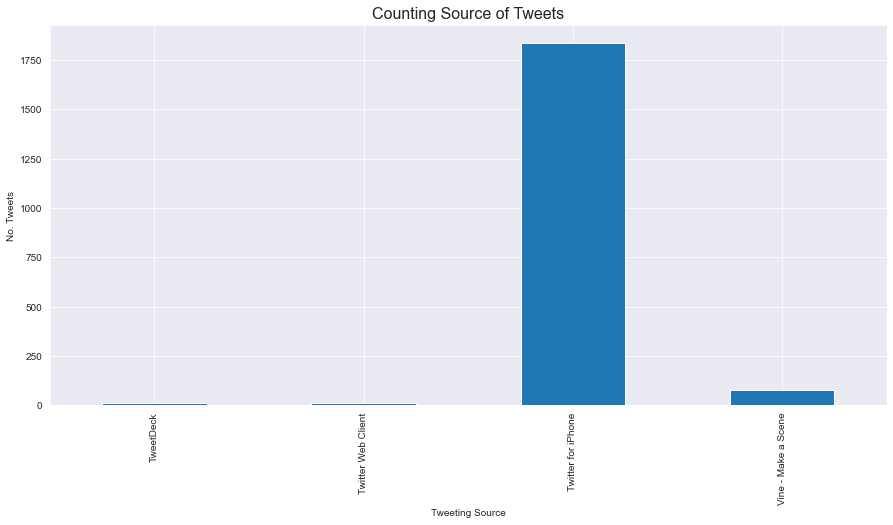

In [ ]:
plt.figure(figsize = [15, 7])

full_archive.groupby('source')['tweet_id'].count().plot(kind='bar')

plt.title('Counting Source of Tweets', size='16')
plt.xlabel('Tweeting Source')
plt.ylabel('No. Tweets');

##### *from the figure above, it is clear that twitter for iphone is the most used application for tweeting in this WeRateDogs followed by Vine*

-----------------------------------------

#### *2- what are the most common words in tweets associated with dogs in doggo stage?*

The following code was adapted from a web page named <a href='https://www.datacamp.com/community/tutorials/wordcloud-python'> Generating WordClouds in Python</a>.

In [ ]:
pupper_set = full_archive.query('stage == "doggo"')

#generating a full text of all words in doggo texts
full_text = " ".join(x for x in pupper_set.text)

#choosing the word that we don't want it to apear in the word cloud
stopwords = set(STOPWORDS)
stopwords.update(["https", "pupper", "dog_rates", "CO", "af","RT","doggo",'vid','tho','ckin'])

In [ ]:
from PIL import Image

#creating a mask from a given image
dog_mask = np.array(Image.open("dog_pic2.png"))

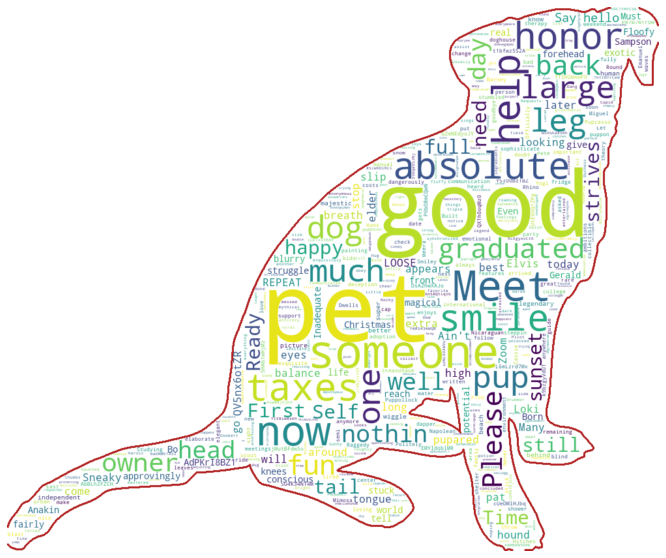

In [ ]:
wc = WordCloud(background_color="white", max_words=1000, mask=dog_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(full_text)

# show
plt.figure(figsize=[15,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

##### *Voila! the word cloud generated the most common words associated with the dogs in doggo stage. the words include smile, good, meet, pet and help. which is mostly positive words.*![image.png](attachment:740e3ffc-483c-4005-9a99-36c05289e5df.png)

---------------------------

#### *3- what are the most common hour of dogs rating tweets?*

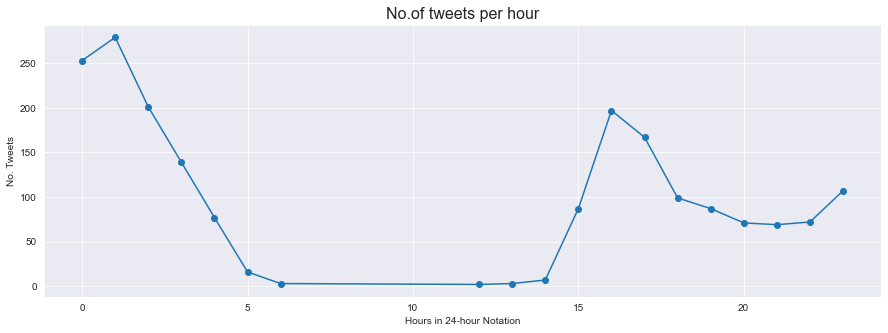

In [ ]:
plt.figure(figsize = [15, 5])

full_archive.groupby(full_archive.timestamp.dt.hour).tweet_id.count().plot(kind='line', marker='o')

plt.title('No.of tweets per hour', size='16')
plt.xlabel('Hours in 24-hour Notation')
plt.ylabel('No. Tweets');

##### *we can see from the above figure that the most common tweeting hour is between 1 am - 2 am*

---------------------------

#### *4- What is the stage that got the most average retweet? how about the most favorited one?*

In [ ]:
full_archive.groupby('stage').mean()[['retweet_count','favorite_count']]

,retweet_count,favorite_count
stage,,
doggo,5872.629630,14686.012346
floofer,4243.625000,12613.625000
pupper,2435.369159,6209.233645
puppo,5880.586207,17574.655172


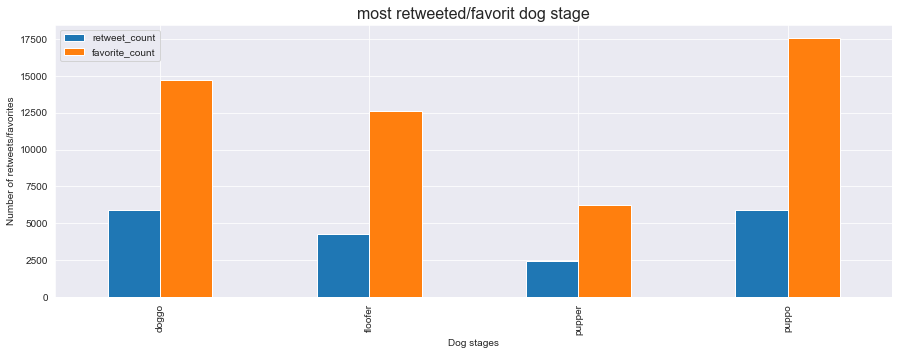

In [ ]:
full_archive.groupby('stage').mean()[['retweet_count','favorite_count']].plot(kind='bar', figsize=(15,5))

plt.title('most retweeted/favorit dog stage', size='16')
plt.xlabel('Dog stages')
plt.ylabel('Number of retweets/favorites');

##### *We can see from the above figure that the most retweeted stage is puppo with small difference margin from doggo. In term of favorited tweets, puppo is clearly the highest among the other stages followed by doggo.*

#### *5- What are the top ten favorited bread? how about the top retweeted?*

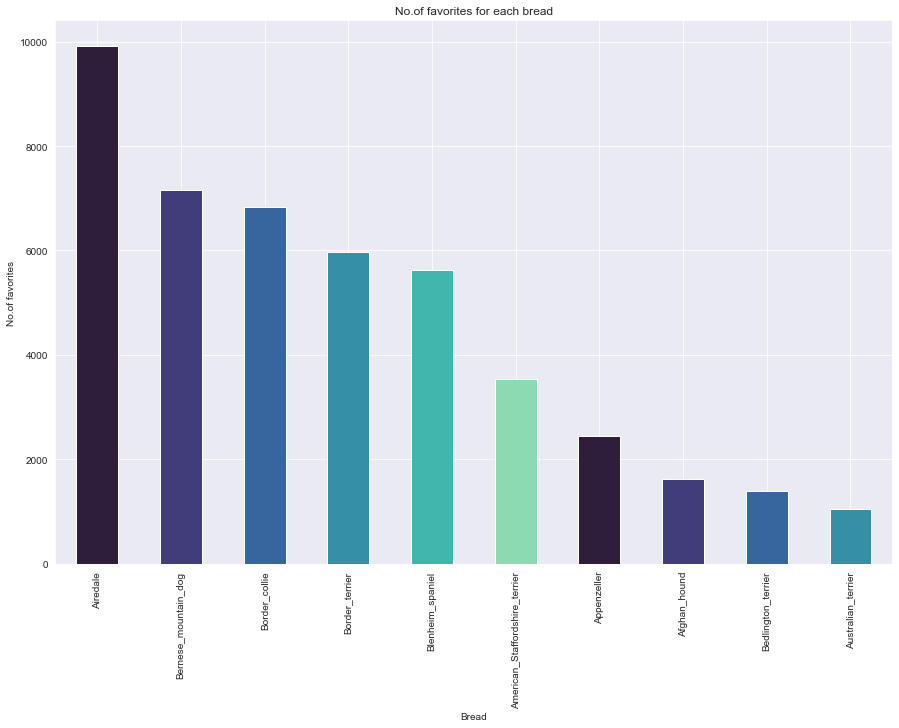

In [ ]:
plot = full_archive.groupby('Prediction')['favorite_count'].mean().head(10).sort_values(ascending=False)

plot.plot(kind='bar', figsize=(15,10), color=sns.color_palette("mako"))

plt.title('No.of favorites for each bread')
plt.xlabel('Bread')
plt.ylabel('No.of favorites');

##### *from the figure, we can see that the top 10 breads in average favorites. the tob bread was Airdale followed by Bernese_mountain_dog*

In [ ]:
full_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936 entries, 0 to 1935
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1936 non-null   object             
 1   timestamp                   1936 non-null   datetime64[ns, UTC]
 2   source                      1936 non-null   object             
 3   text                        1936 non-null   object             
 4   retweeted_status_id         157 non-null    float64            
 5   retweeted_status_user_id    157 non-null    float64            
 6   retweeted_status_timestamp  157 non-null    object             
 7   expanded_urls               1881 non-null   object             
 8   rating_numerator            1936 non-null   int64              
 9   rating_denominator          1936 non-null   int64              
 10  name                        1275 non-null   object          